# Mini-Project: SVM&LR Classification

Andrew Abbott  
MSDS 7331  
February 19, 2017

The data is located at [https://www.kaggle.com/START-UMD/gtd](https://www.kaggle.com/START-UMD/gtd)

Much of the code is adapted from Dr. Larsen's class jupyter notebook.

## Business Understanding:

The data used in this assignment is taken from the Global Terrorism Database (GTD), maintained by the National Consortium for the Study of Terroism and Responses to Terorism (START). The GTD is open-source and contains data on more than 150,000 terrorist or possibly terrorist attacks from around the globe from 1970 to 2015 (except for 1993). There are more than one hundred attributes including location, date, taget, victims, tactics, and perpetrators.

It is important to note the definition of terrorism used in this collection.

> "The threatened or actual use of illegal force and violence by a non-state actor to attain a political, economic, religious, or social goal through fear, coercion, or intimidation."

> "The exclusive pursuit of profit does not satisfy this criterion."

I will seek to identify which charactersitics of attacks are most predictive of U.S. casualties. A good prediction algorithm would reveal a relationship between those attributes that contribute to the likelihood of American casualties.

## Data Understanding:  

The data includes 137 attributes, many of which are redundant or unrelated to the purpose of this study. A Codebook containing a description of each of the attributes can be accessed at [http://start.umd.edu/gtd/downloads/Codebook.pdf](http://start.umd.edu/gtd/downloads/Codebook.pdf).

In [147]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/globalterrorismdb_0616dist.csv', encoding='ISO-8859-1', 
                 usecols=[1,2,3,8,10,19,20,21,22,26,27,29,35,41,71,84,100,101,103,135])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156772 entries, 0 to 156771
Data columns (total 20 columns):
iyear              156772 non-null int64
imonth             156772 non-null int64
iday               156772 non-null int64
country_txt        156772 non-null object
region_txt         156772 non-null object
crit1              156772 non-null int64
crit2              156772 non-null int64
crit3              156772 non-null int64
doubtterr          156771 non-null float64
success            156772 non-null int64
suicide            156772 non-null int64
attacktype1_txt    156772 non-null object
targtype1_txt      156772 non-null object
natlty1_txt        156772 non-null object
nperps             85640 non-null float64
weaptype1_txt      156772 non-null object
nkill              147827 non-null float64
nkillus            92315 non-null float64
nwound             142572 non-null float64
INT_ANY            156772 non-null int64
dtypes: float64(5), int64(9), object(6)
memory usage: 2

To verify data quality I check for missing values, outliers, and duplicates. 

For the numerical attributes containing the numbers of killed and perpetrators, the value is often missing. For number of perpetrators, when the number is not reported, the value is missing or "-99", these are removed. For numbers of killed, a missing value means that the information is not reported or is too vague to be of use, these are also removed. However, if the total number killed is given as zero, and the number of US killed is not listed, it will be replaced with zero. 

I also removed all records with zeros in the month field and replaced zero day values with 1. Next I combined the year, month, and day into a 'date' field and mapped the boolean fields into boolean types. For that mapping, -9 and -99 are mapped to False. 

There were 4 extreme outliers as far as number of perpetrators. Two of the attacks were committed by over 20,000 people and a third by 10,000. These types of attacks may be more accurately called revolts or uprisings than terror attacks so they will be excluded here.

Duplicates could occur if the same event was reported by multiple sources. I will check for duplicates and remove them.

In [151]:
df = df.dropna(subset = ['nkill', 'nperps', 'country_txt'])
##df['nkill'] = df['nkill'].astype(float)
df['nkillus'] = df['nkillus'].fillna(0).astype(int)
df['nwound'] = df['nwound'].fillna(0).astype(int)
df['iyear'] = df['iyear'].astype(int)
row_index = df.iday == 0
df.loc[row_index,'iday'] = 1
df = df[(df.imonth != 0) & (df.doubtterr != 1) & (df.nperps < 5000) & (df.nperps >= 0)]
df['date'] = pd.to_datetime(df.iyear+df.imonth+df.iday)
d = {0:0, 1:1, -9:0}
df['crit1'] = df['crit1'].map(d)
df['crit2'] = df['crit2'].map(d)
df['crit3'] = df['crit3'].map(d)
df['doubtterr'] = df['doubtterr'].map(d)
df['suicide'] = df['suicide'].map(d)
df['success'] = df['success'].map(d)
df['Int_Motive'] = df['INT_ANY'].map(d)
df['weaptype1_txt'] = df['weaptype1_txt'].replace(" ", "")
df.groupby(['date','country_txt','nkill']).size() 
df = df.drop_duplicates(['date','country_txt','nkill'])

Next I create a new data frame containing only the attributes I want to keep and rename them to more readable names. I also create new variables that indicate if there was a US killed or wounded.

In [152]:
terror = df[['iyear','imonth','date','country_txt','region_txt','crit1','crit2','crit3','success','suicide','attacktype1_txt',
                  'targtype1_txt','natlty1_txt','nperps','weaptype1_txt','nkill','nkillus','nwound','Int_Motive']]
terror = terror.rename(
    columns = {'country_txt':'Country','region_txt':'Region','crit1':'Criteria_1','crit2':'Criteria_2',
               'crit3':'Criteria_3','success':'Success','suicide':'Suicide',
               'attacktype1_txt':'Attack_Type','targtype1_txt':'Target_Type','natlty1_txt':'Target_Nationality',
               'nperps':'Num_Perps','weaptype1_txt':'Weapon_Type','nkill':'Num_Killed','nkillus':'Num_Killed_US',
               'nwound':'Num_Wounded'})
terror['US_Killed'] = np.where(terror['Num_Killed_US']>0, True, False)
#Since we want to predict if there were US Casualties, and we have made the US_killed variable, I will remove the Num_Killed_US variable.
terror = terror.drop(['Num_Killed_US'], axis = 1)
#Date as a date time stamp is not useful in the regression, SVM
terror = terror.drop(['date'], axis = 1)

In [153]:
terror.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8710 entries, 6 to 156728
Data columns (total 18 columns):
iyear                 8710 non-null int32
imonth                8710 non-null int64
Country               8710 non-null object
Region                8710 non-null object
Criteria_1            8710 non-null int64
Criteria_2            8710 non-null int64
Criteria_3            8710 non-null int64
Success               8710 non-null int64
Suicide               8710 non-null int64
Attack_Type           8710 non-null object
Target_Type           8710 non-null object
Target_Nationality    8710 non-null object
Num_Perps             8710 non-null float64
Weapon_Type           8710 non-null object
Num_Killed            8710 non-null float64
Num_Wounded           8710 non-null int32
Int_Motive            8710 non-null int64
US_Killed             8710 non-null bool
dtypes: bool(1), float64(2), int32(2), int64(7), object(6)
memory usage: 1.1+ MB


There are 6 categorical variables remaining, let's look at these.

In [154]:
terror[['Country','Region','Attack_Type','Target_Type','Target_Nationality','Weapon_Type']].describe().transpose()

,count,unique,top,freq
Country,8710,173,Iraq,674
Region,8710,12,Middle East & North Africa,2198
Attack_Type,8710,9,Bombing/Explosion,2923
Target_Type,8710,22,Private Citizens & Property,1969
Target_Nationality,8710,178,Iraq,652
Weapon_Type,8710,11,Firearms,4110


In [155]:
#Some of these are redundant. Region is determined by Country, so we can drop Country'
terror = terror.drop(['Country'], axis = 1)

#Target Nationality has 178 unique value, so would be a mess to onehotencode. 
terror = terror.drop(['Target_Nationality'], axis = 1)

#Finally, Weapon type and Attack type are redundant. I will use attack type.
terror = terror.drop(['Weapon_Type'], axis = 1)

In [156]:
terror.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8710 entries, 6 to 156728
Data columns (total 15 columns):
iyear          8710 non-null int32
imonth         8710 non-null int64
Region         8710 non-null object
Criteria_1     8710 non-null int64
Criteria_2     8710 non-null int64
Criteria_3     8710 non-null int64
Success        8710 non-null int64
Suicide        8710 non-null int64
Attack_Type    8710 non-null object
Target_Type    8710 non-null object
Num_Perps      8710 non-null float64
Num_Killed     8710 non-null float64
Num_Wounded    8710 non-null int32
Int_Motive     8710 non-null int64
US_Killed      8710 non-null bool
dtypes: bool(1), float64(2), int32(2), int64(7), object(3)
memory usage: 961.2+ KB


In [157]:
terror[['Region','Attack_Type','Target_Type']].describe().transpose()

,count,unique,top,freq
Region,8710,12,Middle East & North Africa,2198
Attack_Type,8710,9,Bombing/Explosion,2923
Target_Type,8710,22,Private Citizens & Property,1969


In [158]:
# perform one-hot encoding of the categorical data
tmp_df = pd.get_dummies(terror.Region,prefix='Region')
terror = pd.concat((terror,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(terror.Attack_Type,prefix='Attack_Type')
terror = pd.concat((terror,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(terror.Target_Type,prefix='Target_Type')
terror = pd.concat((terror,tmp_df),axis=1) # add back into the dataframe

# Now let's clean up the dataset
if 'Region' in terror:
    del terror['Region'] 
if 'Attack_Type' in terror:    
    del terror['Attack_Type'] 
if 'Target_Type' in terror:    
    del terror['Target_Type'] 
    
terror.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8710 entries, 6 to 156728
Data columns (total 55 columns):
iyear                                              8710 non-null int32
imonth                                             8710 non-null int64
Criteria_1                                         8710 non-null int64
Criteria_2                                         8710 non-null int64
Criteria_3                                         8710 non-null int64
Success                                            8710 non-null int64
Suicide                                            8710 non-null int64
Num_Perps                                          8710 non-null float64
Num_Killed                                         8710 non-null float64
Num_Wounded                                        8710 non-null int32
Int_Motive                                         8710 non-null int64
US_Killed                                          8710 non-null bool
Region_Australasia & Oceania        

## Training and Testing Split

In [159]:
from sklearn.model_selection import ShuffleSplit

if 'US_Killed' in terror:
    y = terror['US_Killed'].values
    del terror['US_Killed']
    X = terror.values
    
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                        test_size = 0.2)

print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


# Logistic Regression

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt


for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    

====Iteration 0  ====
accuracy 0.978760045924
confusion matrix
 [[1705    0]
 [  37    0]]
====Iteration 1  ====
accuracy 0.978760045924
confusion matrix
 [[1705    0]
 [  37    0]]
====Iteration 2  ====
accuracy 0.978760045924
confusion matrix
 [[1705    0]
 [  37    0]]


In [161]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)

[ 0.9793341   0.9804822   0.98220436]


In [162]:
def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None)
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

<function __main__.lr_explor>

## Interpreting weights

Now we will look at the trained model for logistic regression and interpret the weights. We need to normalize the features so that the weight magnitudes reflect their actual predictive power.

In [163]:
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test)

lr_clf = LogisticRegression(penalty='l2', C=0.05)
lr_clf.fit(X_train_scaled, y_train)

y_het = lr_clf.predict(X_test_scaled)

zip_vars = zip(lr_clf.coef_.T,terror.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
    

Attack_Type_Facility/Infrastructure Attack has weight of -0.167202592371
Region_Sub-Saharan Africa has weight of -0.139413223966
Num_Perps has weight of -0.111050433637
Region_Eastern Europe has weight of -0.0947432436016
Attack_Type_Unarmed Assault has weight of -0.093350753794
Region_Central America & Caribbean has weight of -0.0850747616305
Region_South America has weight of -0.0795110402644
Target_Type_Maritime has weight of -0.0735487897668
Attack_Type_Hostage Taking (Kidnapping) has weight of -0.0717697849387
Target_Type_Police has weight of -0.06584769189
Target_Type_NGO has weight of -0.0635826737051
Target_Type_Journalists & Media has weight of -0.0606048118834
Attack_Type_Bombing/Explosion has weight of -0.057475252242
Attack_Type_Unknown has weight of -0.0550515739967
iyear has weight of -0.0499686949058
Target_Type_Government (General) has weight of -0.0484997330794
Target_Type_Violent Political Party has weight of -0.045801189589
Target_Type_Utilities has weight of -0.0434

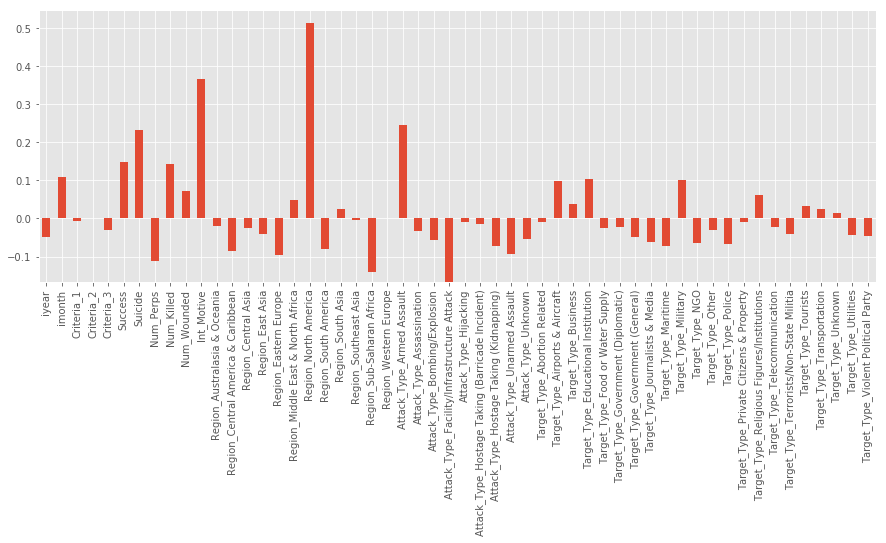

In [164]:
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0], index = terror.columns)
weights.plot(kind = 'bar')
plt.show()

The trained logistic regression model with normalized weights tells us that some variables are more important. Looking at the weights, the most important are:

1. Region_North America
2. Int_Motive
3. Attack_Type_Armed Assault
4. Suicide
5. Success


These make sense when predicting the likelihood of an American Death. If the attack takes place in North America, it would be highly unlikely for there to not be an Amerian death if there were any deaths at all. An international motive is predictive likely because the US is viewed as a colonial power by many terrorists. Armed assaults and suicides are the types of attacks very likely to cause deaths and therefore US deaths. The 5th most predictive variable is success, an unsuccessful attack by definition would not have any US deaths.



# Support Vector Machines

In [165]:
# Run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) 
X_test_scaled = scl_obj.transform(X_test) 

In [166]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') 
svm_clf.fit(X_train_scaled, y_train)

y_hat = svm_clf.predict(X_test_scaled) # get test set predictions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.982778415614
[[1712    0]
 [  30    0]]


In [167]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(393, 54)
(393,)
[264 129]


[[ -4.79946550e-05   2.82649337e-05  -1.70696790e-15   0.00000000e+00
   -5.89805982e-16   9.62258435e-05   2.18149600e-05  -3.50961367e-03
    4.45536079e-04  -1.50987009e-04   9.93942859e-05   2.94902991e-15
    8.60851977e-06  -4.02455846e-16  -1.06581410e-14  -3.39371175e-04
    2.61394223e-05   1.03174263e-04   7.68808161e-05  -3.64232715e-05
    7.85957060e-05  -3.22826593e-05   4.44724147e-05   8.15473343e-05
   -1.26454989e-05  -3.18957549e-05  -5.31425264e-05   2.18419328e-05
    2.56482470e-05  -5.45423497e-05  -4.95437025e-15  -1.37390099e-14
    2.85966729e-06  -2.94214332e-05   1.86819508e-05   9.48853294e-06
    2.88657986e-15  -4.20370514e-05   3.38990134e-05  -2.69261313e-05
   -1.34924259e-04   3.40077039e-05   2.48220810e-05   6.60582700e-15
   -4.26410872e-06  -1.94987977e-06  -2.17860871e-06   3.04617442e-15
   -5.91073170e-05   3.33622019e-14   1.99232715e-05   2.36028819e-05
   -3.99680289e-15   4.99600361e-15]]


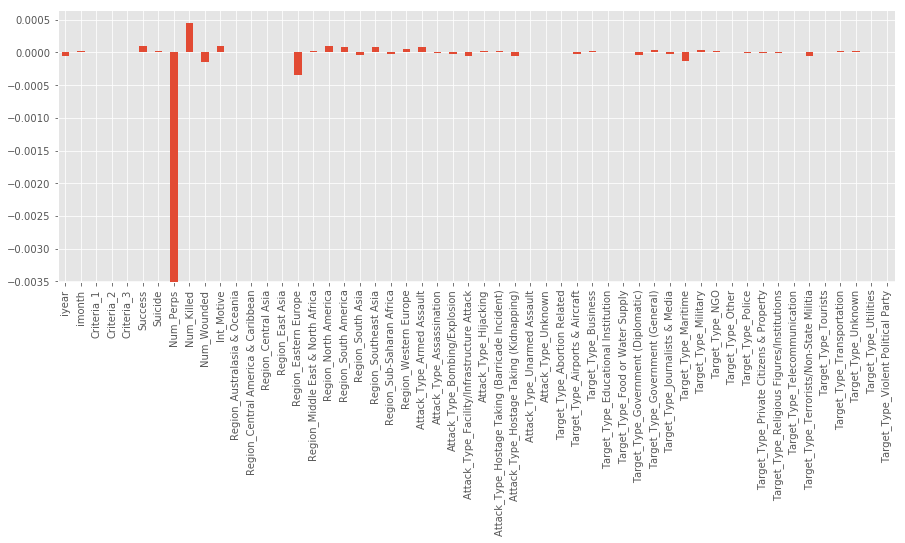

In [168]:
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=terror.columns)
weights.plot(kind='bar')

The SVM model also tells us that some variables are more important. Looking at the weights, the most important are:

1. Num_Perps
2. Num_Killed
3. Success
4. Int_Motive
5. Region_North America


These make some sense when predicting the likelihood of an American Death. I do not immediately see a reason that number of perpetrators is weighted highest here, especially after the logostic regression did not weight it heavily. Higher number killed in an attack could predict due to a higher number of victims meaning a higher probability that at least one is American. The 3rd  most predictive variable is success, an unsuccessful attack by definition would not have any US deaths. An international motive is predictive likely because the US is viewed as a colonial power by many terrorists. Armed assaults and suicides are the types of attacks very likely to cause deaths and therefore US deaths. If the attack takes place in North America, it would be highly unlikely for there to not be an Amerian death if there were any deaths at all.

In [171]:
pd.set_option('chained_assignment',None)
df_tested_on = terror.iloc[train_indices] 
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['US_Killed'] = y[svm_clf.support_] # add back in the 'US_Killed' Column to the pandas dataframe
terror['US_Killed'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 520 to 11599
Data columns (total 55 columns):
iyear                                              393 non-null int32
imonth                                             393 non-null int64
Criteria_1                                         393 non-null int64
Criteria_2                                         393 non-null int64
Criteria_3                                         393 non-null int64
Success                                            393 non-null int64
Suicide                                            393 non-null int64
Num_Perps                                          393 non-null float64
Num_Killed                                         393 non-null float64
Num_Wounded                                        393 non-null int32
Int_Motive                                         393 non-null int64
Region_Australasia & Oceania                       393 non-null uint8
Region_Central America & Caribbean             

# Compare Models

I prefer the logistic regression model. The scaled weights very clearly tell me which variables contribute to the prediction. The accuracies of the two methods were similar. I also did not notice a time difference for my models.